In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
import datetime
from scipy.optimize import curve_fit
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import random
import time
from scipy.interpolate import interp1d

In [3]:
SMALL_DT = 64
COLORS = ['black', 'grey', 'lightgrey', 'lightcoral', 'brown', 'maroon', 'red', 'salmon', 'crimson', 'peru', 'navajowhite', 'orange', 'gold', 'yellow', 'darkkhaki', 'chartreuse', 'green', 'olive', 'springgreen', 'aqua', 'teal', 'darkgreen', 'deepskyblue', 'navy', 'blue', 'indigo', 'mediumpurple', 'purple', 'violet', 'magenta', 'hotpink', 'pink']

In [4]:
def open_datacube(directory):
    with xr.open_dataset(directory, decode_timedelta=False) as ds:
        data = ds
    return data

In [5]:
def select_in_range(data, start, end):
    return data.where(data.mid_date>np.datetime64(start)).where(data.mid_date<np.datetime64(end))

In [6]:
def get_images_and_vel(cube, x, y, zoom=False): # get the velocities and img1 and img2 dates for an x, y coordinate
    vels = []
    img1s = []
    img2s = []
    for md in gl_cube.mid_date.values:
        if (not zoom) or (md.astype('M8[ms]').astype('O').year > zoom[0] and md.astype('M8[ms]').astype('O').year < zoom[1]):
            img1 = cube.acquisition_img2.sel(mid_date=md).values
            img2 = cube.acquisition_img1.sel(mid_date=md).values
            if type(img1) == np.ndarray:
                img1 = cube.acquisition_img2.sel(mid_date=md).values[0]
                img2 = cube.acquisition_img1.sel(mid_date=md).values[0]
            vel_val = cube.v.sel(x=cube.x[x], y=cube.y[y], mid_date=md).values
            vel = vel_val

            if vel_val.size > 1:
                for v in vel_val:
                    if not np.isnan(v):
                        vel = v
            if type(vel) == np.ndarray and vel.size > 1:
                vel = vel[0]
            if type(vel) == np.ndarray and vel.size==1:
                vel = vel.item()
            vels.append(vel)
            img1s.append(img1)
            img2s.append(img2)
    return np.array(vels), np.array(img1s), np.array(img2s)

In [7]:
def plotting_timespan(xmin, xmax, y):
    plt.figure(figsize=(20,5))
    plt.hlines(y, xmin, xmax, color='red')
    plt.show()
    
def plotting_timespan_color_coded(xmin, xmax, y, dt): #horizontal lines, color coded for dts
    dts = (xmax-xmin)
    small_dt = np.timedelta64(dt, 'D').astype('timedelta64[ns]')
    random_colors = ['b', 'g', 'r', 'black', 'maroon', 'peru', 'orange', 'yellow', 'chartreuse', 'cyan', 'darkviolet', 'magenta', 'pink']
    col = np.where(dts<small_dt, random.choice(random_colors), 'white')
    plt.figure(figsize=(20,5))
    for i in range(len(y)):
        if dts[i] < small_dt:
            plt.hlines(y[i], xmin[i], xmax[i], color='r')
        else:
            plt.hlines(y[i], xmin[i], xmax[i], color='lightblue')
    handles, labels = plt.gca().get_legend_handles_labels()
    blueline = Line2D([0], [0], label = f'dt > {dt} days',color='lightblue')
    redline = Line2D([0], [0], label = f'dt < {dt} days',color='r')
    handles.extend([blueline,redline])
    plt.legend(handles=handles)
    plt.show()
    return dts
    
def plotting_same_plot(x1, y1, x2, y2, y_axis=''):
    plt.figure(figsize=(20,5))
    plt.plot(x1, y1, color='blue', zorder=1, linewidth=1)
    plt.scatter(x2, y2, color='red', s=8, zorder=2)
    plt.xlabel('Time')
    plt.ylabel(y_axis)
    plt.title(y_axis + " over time")
    plt.show()

In [8]:
def plotting_by_month(data): # pass in an xarray DataArray
    sorted_data = data.sortby('mid_date')
    all_vel = sorted_data.dropna('mid_date')
    all_dates = all_vel.mid_date.values.astype('M8[ms]').astype('O')
    all_times = np.array(list(map(datetime.date.toordinal, all_dates)))

    year = all_dates[0].year
    end_year = all_dates[-1].year
    i = 0

    fig, ax = plt.subplots(figsize=(20, 5))
    month_day_fmt = mdates.DateFormatter('%d %b')
    ax.xaxis.set_major_formatter(month_day_fmt)
    min_year = 1987
    color = 5
    legend_colors = []
    while year <= end_year:
        if i > len(all_dates)-1:
            break
        if all_dates[i].year != year:
            year = all_dates[i].year
            color += 1
        date = datetime.datetime(2000, all_dates[i].month, all_dates[i].day, all_dates[i].hour, all_dates[i].minute, all_dates[i].second, all_dates[i].microsecond)
        if all_dates[i].year in legend_colors:
            plt.scatter(date, all_vel.values[i], c=COLORS[all_dates[i].year - min_year])
        else:
            plt.scatter(date, all_vel.values[i], c=COLORS[all_dates[i].year - min_year], label=all_dates[i].year)
            legend_colors.append(all_dates[i].year)
        i+=1
    plt.legend()
    plt.show()

In [9]:
def plotting_by_months(vel, mid_date): # pass in numpy arrays
    def make_same_year(date):
        return datetime.datetime(2000, date.month, date.day, date.hour, date.minute, date.second, date.microsecond)

    mid_dates, vels = (np.array(t) for t in zip(*sorted(zip(mid_date, vel))))
    min_year = 1987
    
    fig, ax = plt.subplots(figsize=(20, 5))
    month_day_fmt = mdates.DateFormatter('%d %b')
    ax.xaxis.set_major_formatter(month_day_fmt)
    
    legend_colors = []
    for i in range(len(vels)):
        date = make_same_year(mid_dates[i])
        if mid_dates[i].year in legend_colors:
            plt.scatter(date, vels[i], c=COLORS[mid_dates[i].year - min_year])
        else:
            plt.scatter(date, vels[i], c=COLORS[mid_dates[i].year - min_year], label=mid_dates[i].year)
            legend_colors.append(mid_dates[i].year)

    plt.legend()
    plt.show()

In [10]:
def select_by_dt(vels, img1s, img2s, dt, short_dt=True): # filter out long (default) or short dts
    dts = img2s-img1s
    small_dt = np.timedelta64(dt, 'D').astype('timedelta64[ns]')
    if short_dt:
        new_vels = np.array([vels[i] for i in range(len(vels)) if dts[i] < small_dt])
        new_img1s = np.array([img1s[i] for i in range(len(img1s)) if dts[i] < small_dt])
        new_img2s = np.array([img2s[i] for i in range(len(img2s)) if dts[i] < small_dt])
    else:
        new_vels = np.array([vels[i] for i in range(len(vels)) if dts[i] > small_dt])
        new_img1s = np.array([img1s[i] for i in range(len(img1s)) if dts[i] > small_dt])
        new_img2s = np.array([img2s[i] for i in range(len(img2s)) if dts[i] > small_dt])
    return new_vels, new_img1s, new_img2s

In [11]:
def remove_nan(data, dates):
    result = []
    result_dates = []
    for i in range(len(data)):
        if (not np.isnan(data[i])):
            result.append(data[i])
            result_dates.append(dates[i])
    return np.array(result), np.array(result_dates)

In [12]:
def velocity_sin(times, constant, amplitude, phase):
    return constant - amplitude * np.sin(2*np.pi/365 * (times - phase))

def velocity_sin_scaled(times, amplitude, phase):
    return -1*amplitude * np.sin(2*np.pi/365 * (times - phase))

In [13]:
def calc_peak(dates, vels):
    est_peak = dates[np.argmax(vels)]
    est_peak_month = str(est_peak.month)
    est_peak_day = str(est_peak.day)
    if len(est_peak_month) == 1:
        est_peak_month = "0" + est_peak_month
    if len(est_peak_day) == 1:
        est_peak_day = "0" + est_peak_day
    return est_peak_month, est_peak_day

In [14]:
def predict_velocity(velocity, times, function):
    param, param_cov = curve_fit(function, times, velocity)
    if len(param) == 3:
        est_vel, est_amp, est_phase = param
    else:
        est_amp, est_phase = param
    if est_amp < 0:
        est_amp *= -1
        est_phase -= (365/2)
    while est_phase < 0:
        est_phase += 365
    while est_phase > 365:
        est_phase -= 365
    if len(param) == 3:
        return est_vel, est_amp, est_phase
    else:
        return est_amp, est_phase

In [15]:
def rmse(predicted, actual):
    mse = np.mean(np.square(predicted - actual))
    return np.sqrt(mse)

In [17]:
greenland_dir = 'data/Greenland_61.6N_48.1W.nc'
gl_cube = open_datacube(greenland_dir)

In [18]:
gl_cube

<xarray.Dataset>
Dimensions:                    (mid_date: 7073, x: 416, y: 416)
Coordinates:
  * mid_date                   (mid_date) datetime64[ns] 2012-12-30T00:00:00....
  * x                          (x) float64 6.04e+05 6.042e+05 ... 7.036e+05
  * y                          (y) float64 6.887e+06 6.887e+06 ... 6.788e+06
Data variables: (12/42)
    UTM_Projection             object ...
    acquisition_img1           (mid_date) datetime64[ns] ...
    acquisition_img2           (mid_date) datetime64[ns] ...
    autoRIFT_software_version  (mid_date) float64 ...
    chip_size_height           (mid_date, y, x) float32 ...
    chip_size_width            (mid_date, y, x) float32 ...
    ...                         ...
    vy                         (mid_date, y, x) float32 ...
    vy_error                   (mid_date) float64 ...
    vy_stable_shift            (mid_date) float64 ...
    vyp                        (mid_date, y, x) float32 ...
    vyp_error                  (mid_date) float64 ...
    vyp_stable_shift           (mid_date) float64 ...
Attributes:
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    datacube_software_version:  1.0
    date_created:               21-06-2021 18:10:46
    date_updated:               21-06-2021 18:10:46
    institution:                NASA Jet Propulsion Laboratory (JPL), Califor...
    projection:                 32622
    title:                      ITS_LIVE datacube of image_pair velocities

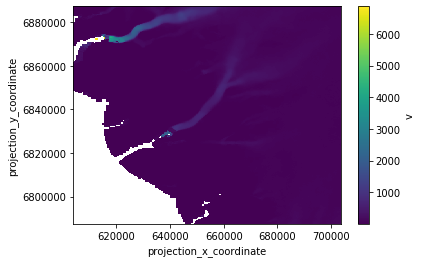

In [19]:
gl_median = gl_cube.v.median(dim='mid_date')
gl_median.plot(x='x', y='y')
plt.show()

Spatial plot of the median velocities for the Greenland data cube.

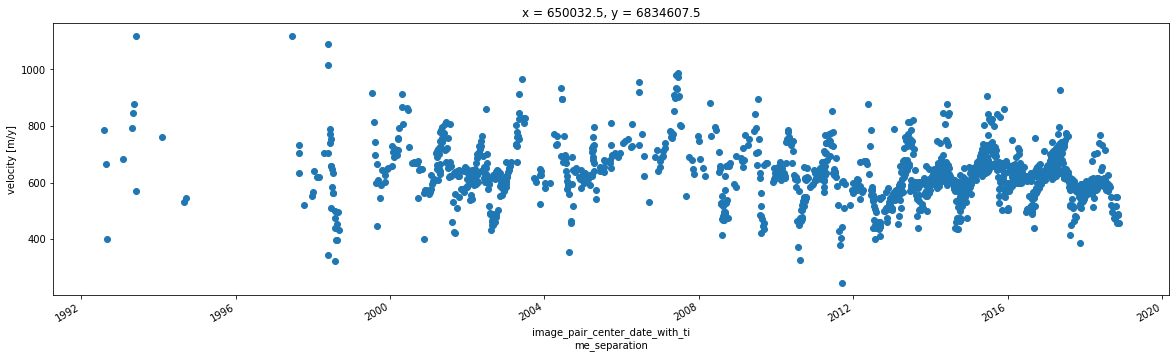

In [20]:
x_coord = 192 # x coord of grid cell
y_coord = 219 # y coord of grid cell

grid_cell_v = gl_cube.v.isel(x=x_coord, y=y_coord)
sorted_v = grid_cell_v.sortby('mid_date')
grid_cell_v.plot(marker='o', linestyle="None", figsize=(20, 5))
plt.show()

Plot of all the velocities of the grid cell through time. 

In [22]:
grid_cell_v

<xarray.DataArray 'v' (mid_date: 7073)>
array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
Coordinates:
  * mid_date  (mid_date) datetime64[ns] 2012-12-30T00:00:00.171000064 ... 201...
    x         float64 6.5e+05
    y         float64 6.835e+06
Attributes:
    best_practice:  velocities should always be merged/averaged using compone...
    description:    velocity magnitude
    grid_mapping:   UTM_Projection
    standard_name:  velocity
    units:          m/y

In [23]:
min_year = pd.to_datetime(min(grid_cell_v.mid_date.values)).year
max_year = pd.to_datetime(max(grid_cell_v.mid_date.values)).year

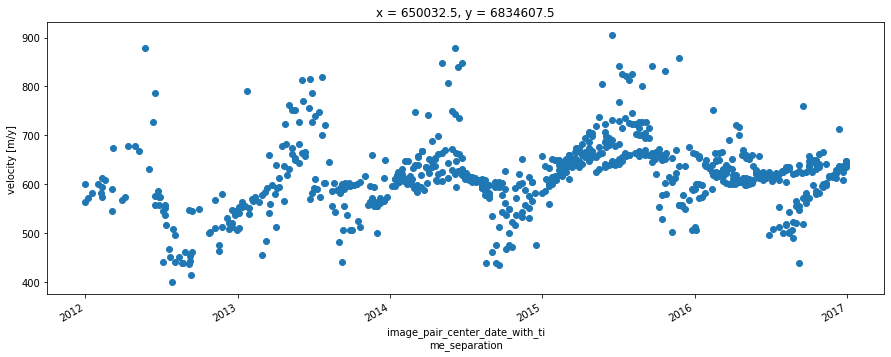

In [24]:
v_in_range = select_in_range(grid_cell_v, "2012", "2017")
v_in_range.plot(marker='o', linestyle="None", figsize=(15, 5))
plt.show()

Velocity at the grid cell between 2012 and 2017

In [25]:
vels, img1s, img2s = get_images_and_vel(gl_cube, x_coord, y_coord)
mid_dates = ((img2s-img1s)/2 + img1s).astype('M8[ms]').astype('O')

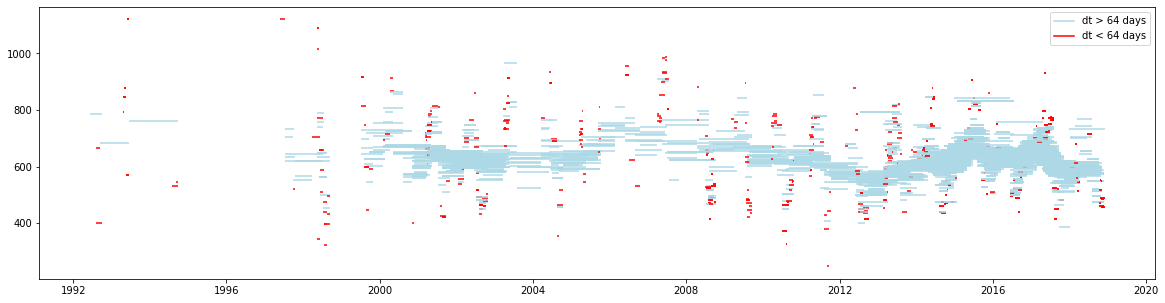

In [26]:
all_dts = plotting_timespan_color_coded(img1s, img2s, vels, 64)

In [27]:
all_dts = all_dts.astype('timedelta64[D]').astype('float')

Seasonal grid cell: Plotting the velocity with horizontal lines to represent the dt length. The red lines show a shorter dt.

In [28]:
mid_x = int(len(gl_cube.x)/2)
mid_y = int(len(gl_cube.y)/2)
vels_mid, img1s_mid, img2s_mid = get_images_and_vel(gl_cube, mid_x, mid_y)

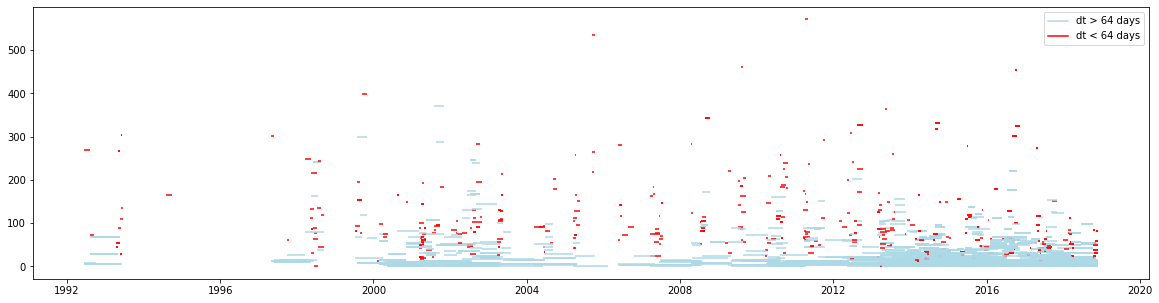

array([14774400000000000,  6220800000000000, 45619200000000000, ...,
       38707200000000000, 19353600000000000, 16588800000000000],
      dtype='timedelta64[ns]')

In [29]:
plotting_timespan_color_coded(img1s_mid, img2s_mid, vels_mid, 64)

Mid grid cell: Plotting the velocity with horizontal lines to represent the dt length. The red lines show a shorter dt.

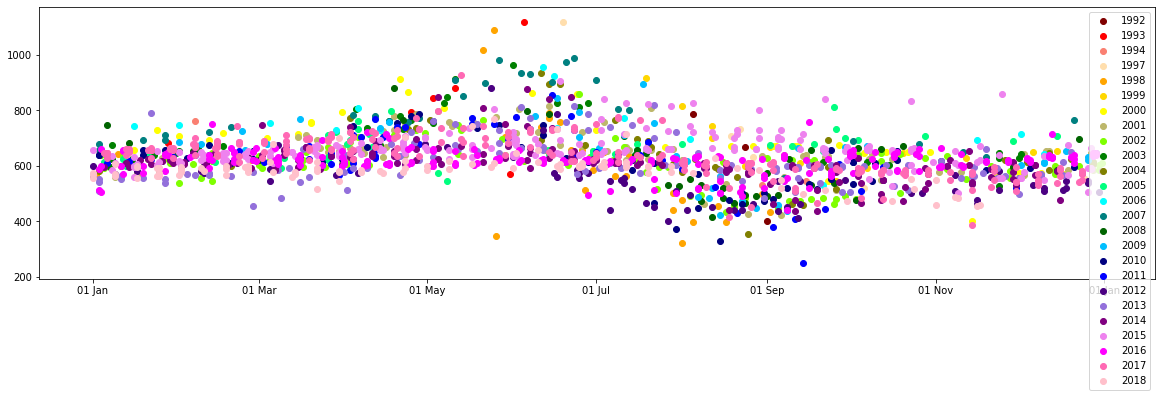

In [30]:
plotting_by_month(grid_cell_v)

Plotted the seasonal trends for all velocities

In [31]:
small_dt_vels, small_dt_img1s, small_dt_img2s = select_by_dt(vels, img1s, img2s, 64)

In [32]:
small_dt_mid_dates = ((small_dt_img2s-small_dt_img1s)/2 + small_dt_img1s).astype('M8[ms]').astype('O')

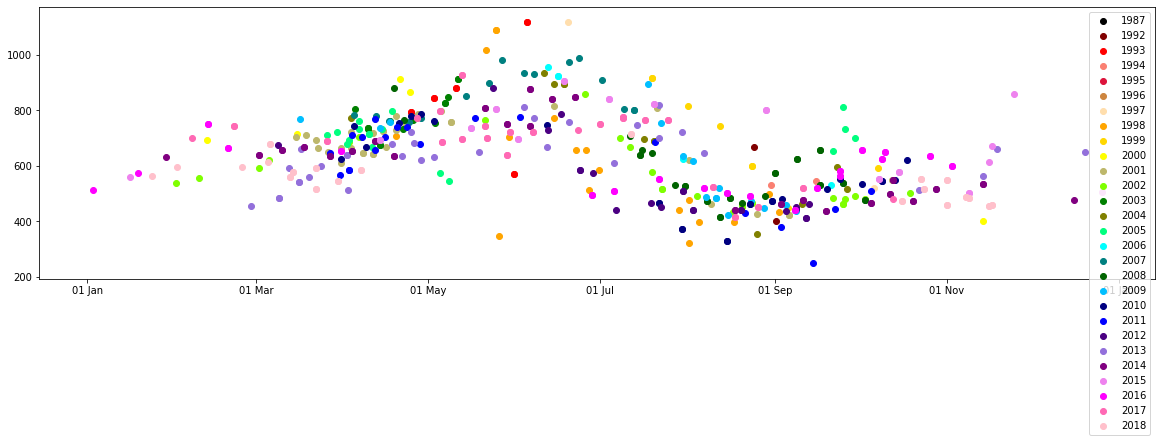

In [33]:
plotting_by_months(small_dt_vels, small_dt_mid_dates)

Plotted the seasonal trends for the shorter dt velocities

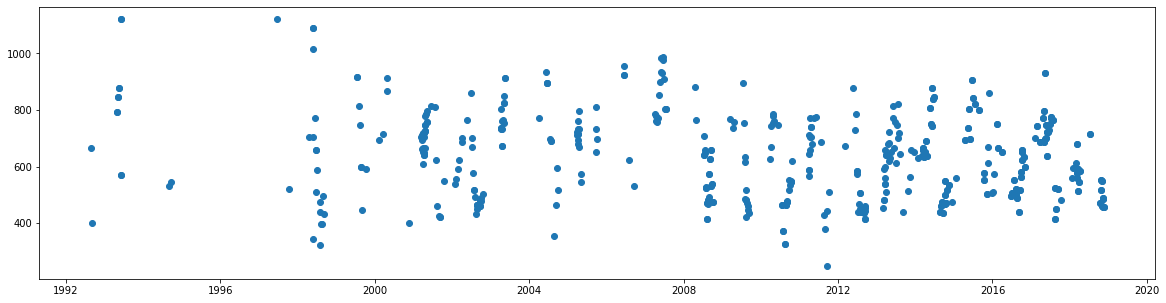

In [34]:
plt.figure(figsize=(20, 5))
plt.scatter(small_dt_mid_dates, small_dt_vels)
plt.show()

Shorter dt velocities through time

In [35]:
displacement = np.cumsum(sorted_v/365)
displacement

<xarray.DataArray 'v' (mid_date: 7073)>
array([   0.    ,    0.    ,    0.    , ..., 2911.5906, 2912.8425,
       2912.8425], dtype=float32)
Coordinates:
  * mid_date  (mid_date) datetime64[ns] 1987-08-22T00:00:00.016000 ... 2018-1...
    x         float64 6.5e+05
    y         float64 6.835e+06

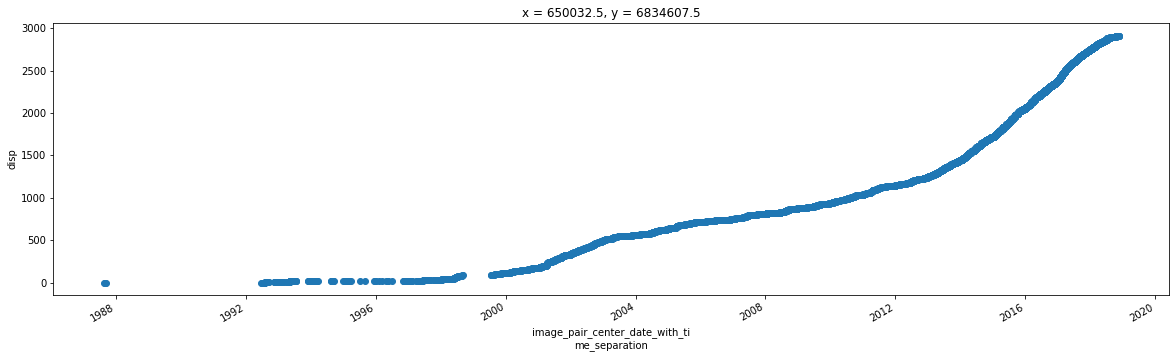

In [36]:
displacement.plot(marker='o', linestyle="None", figsize=(20, 5))
plt.ylabel("disp")
plt.show()

Displacement through for the grid cell

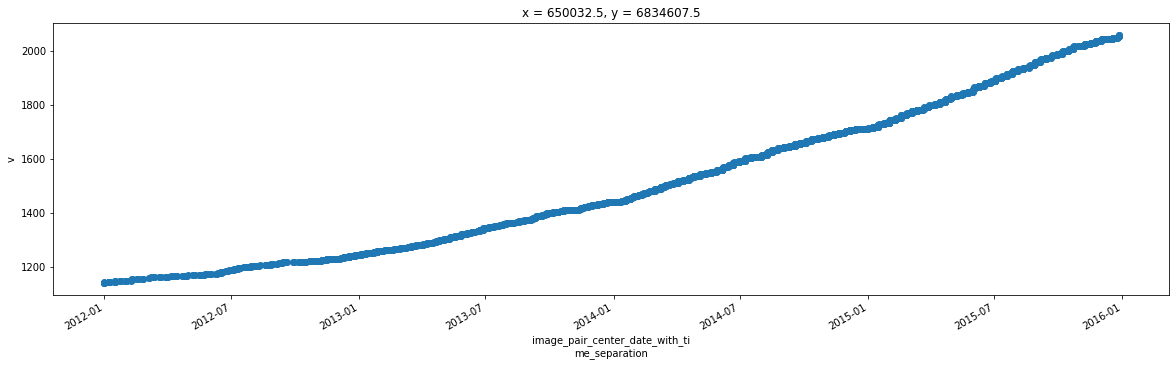

In [37]:
disp_in_range = select_in_range(displacement, "2012", "2016")
disp_in_range = disp_in_range.dropna('mid_date')
disp_in_range.plot(marker='o', linestyle="None", figsize=(20, 5))
plt.show()

Displacement for the grid cell between 2012 and 2016

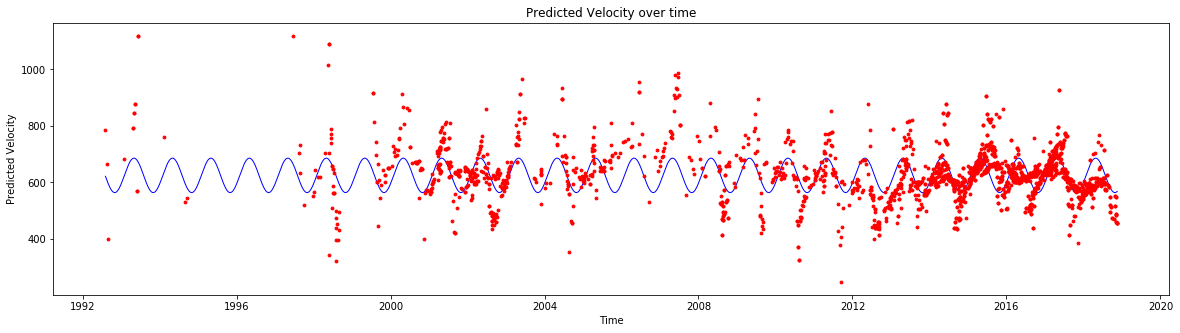

Estimated vertical shift: 625.2334, Estimated amplitude: 60.941, Estimated phase: 331.8816


In [38]:
velocity, dates = remove_nan(vels, mid_dates)
times = np.array(list(map(datetime.date.toordinal, dates)))
est_vel, est_amp, est_phase = predict_velocity(velocity, times, velocity_sin)
TIME_RANGE = np.array(range(min(times), max(times)+1))
DATE_RANGE = np.array(list(map(datetime.date.fromordinal, TIME_RANGE)))
pred_vel = velocity_sin(TIME_RANGE, est_vel, est_amp, est_phase)
plotting_same_plot(DATE_RANGE, pred_vel, times, velocity, "Predicted Velocity")
print(f"Estimated vertical shift: {round(est_vel, 4)}, Estimated amplitude: {round(est_amp, 4)}, Estimated phase: {round(est_phase, 4)}")

Predicted velocity using data from all dts

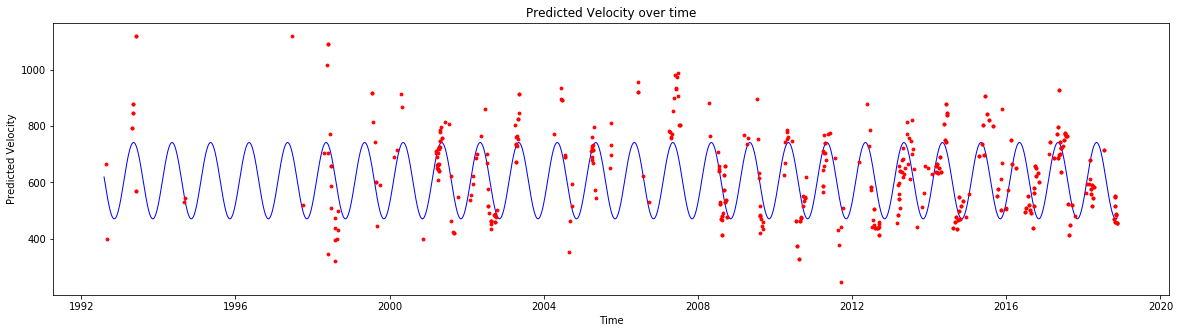

Estimated vertical shift: 606.2984, Estimated amplitude: 135.2731, Estimated phase: 340.6649


In [39]:
velocity_small_dt, dates_small_dt = remove_nan(small_dt_vels, small_dt_mid_dates)
times_small_dt = np.array(list(map(datetime.date.toordinal, dates_small_dt)))
est_vel, est_amp, est_phase = predict_velocity(velocity_small_dt, times_small_dt, velocity_sin)
pred_vel_small_dt = velocity_sin(TIME_RANGE, est_vel, est_amp, est_phase)
plotting_same_plot(DATE_RANGE, pred_vel_small_dt, times_small_dt, velocity_small_dt, "Predicted Velocity")
print(f"Estimated vertical shift: {round(est_vel, 4)}, Estimated amplitude: {round(est_amp, 4)}, Estimated phase: {round(est_phase, 4)}")

Predicted velocity using data with dt less than 64

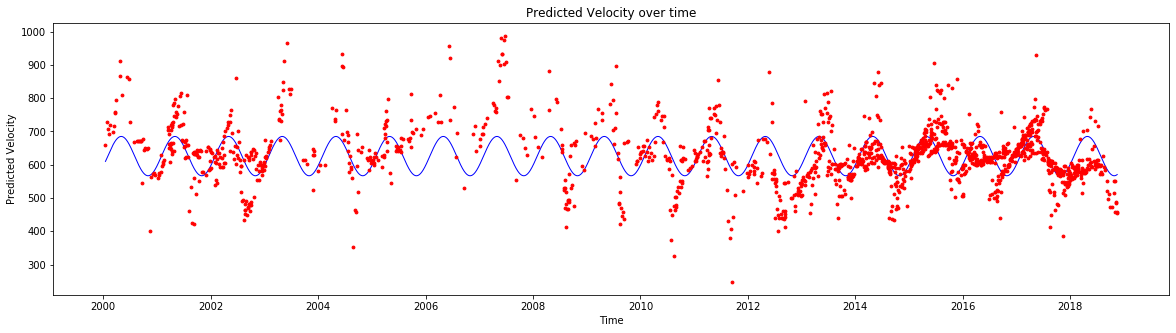

Estimated vertical shift: 625.9122, Estimated amplitude: 59.0588, Estimated phase: 333.3775


In [40]:
v_zoomed = select_in_range(grid_cell_v, "2000", "2019")
velocity_zoom, dates_zoom = remove_nan(v_zoomed.values, v_zoomed.mid_date.values.astype('M8[ms]').astype('O'))
times_zoom = np.array(list(map(datetime.date.toordinal, dates_zoom)))
est_vel, est_amp, est_phase = predict_velocity(velocity_zoom, times_zoom, velocity_sin)
TIME_RANGE_ZOOM = np.array(range(min(times_zoom), max(times_zoom)+1))
DATE_RANGE_ZOOM = np.array(list(map(datetime.date.fromordinal, TIME_RANGE_ZOOM)))
pred_vel_zoom = velocity_sin(TIME_RANGE_ZOOM, est_vel, est_amp, est_phase)
plotting_same_plot(DATE_RANGE_ZOOM, pred_vel_zoom, times_zoom, velocity_zoom, "Predicted Velocity")
print(f"Estimated vertical shift: {round(est_vel, 4)}, Estimated amplitude: {round(est_amp, 4)}, Estimated phase: {round(est_phase, 4)}")

Predicted velocity of using data from all dts from 2000 to 2018

In [41]:
vels_z, img1s_z, img2s_z = get_images_and_vel(gl_cube, x_coord, y_coord, [2000, 2019])
vels_z, img1s_z, img2s_z = select_by_dt(vels_z, img1s_z, img2s_z, 64)

In [42]:
mid_dates_z = ((img2s_z-img1s_z)/2 + img1s_z).astype('M8[ms]').astype('O')

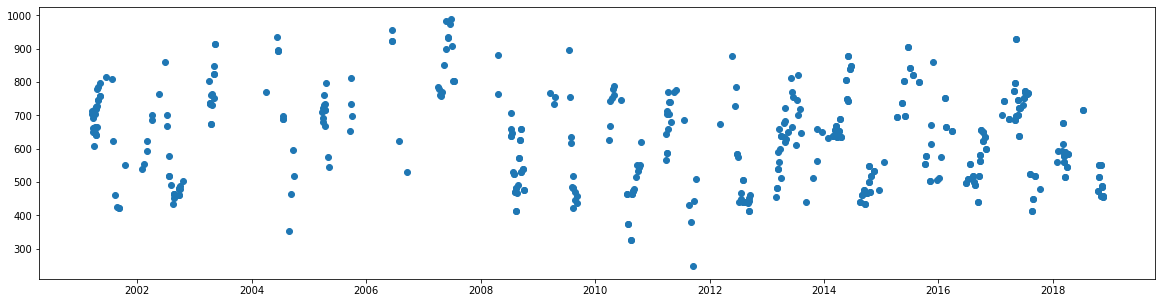

In [43]:
plt.figure(figsize=(20, 5))
plt.scatter(mid_dates_z, vels_z)
plt.show()

Velocities from 2000 to 2018 with a dt of less than 64

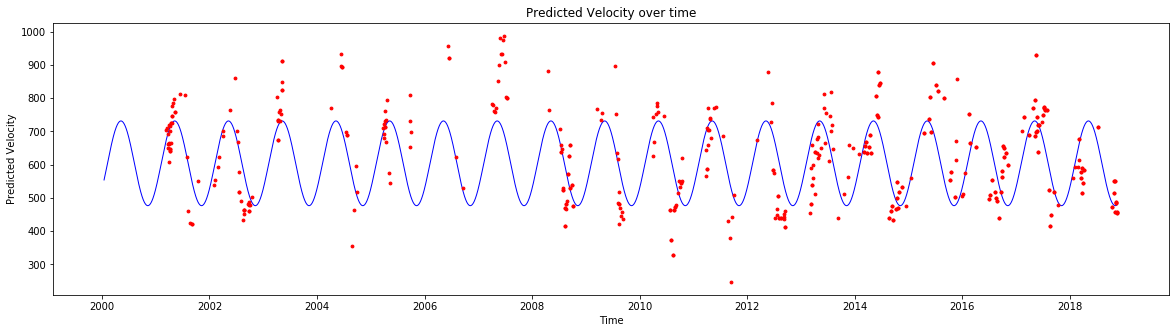

Estimated vertical shift: 604.2361, Estimated amplitude: 127.5404, Estimated phase: 340.9806


In [44]:
velocity_z, dates_z = remove_nan(vels_z, mid_dates_z)
times_z = np.array(list(map(datetime.date.toordinal, dates_z)))
est_vel, est_amp, est_phase = predict_velocity(velocity_z, times_z, velocity_sin)
pred_vel_z = velocity_sin(TIME_RANGE_ZOOM, est_vel, est_amp, est_phase)
plotting_same_plot(DATE_RANGE_ZOOM, pred_vel_z, times_z, velocity_z, "Predicted Velocity")
print(f"Estimated vertical shift: {round(est_vel, 4)}, Estimated amplitude: {round(est_amp, 4)}, Estimated phase: {round(est_phase, 4)}")

Predicted velocity of using data with dts less than 64 from 2000 to 2018

In [45]:
long_dt_vels, long_dt_img1s, long_dt_img2s = select_by_dt(vels, img1s, img2s, 64, False)
long_dt_mid_dates = ((long_dt_img2s-long_dt_img1s)/2 + long_dt_img1s).astype('M8[ms]').astype('O')
long_dt_vels, long_dt_mid_dates = remove_nan(long_dt_vels, long_dt_mid_dates)

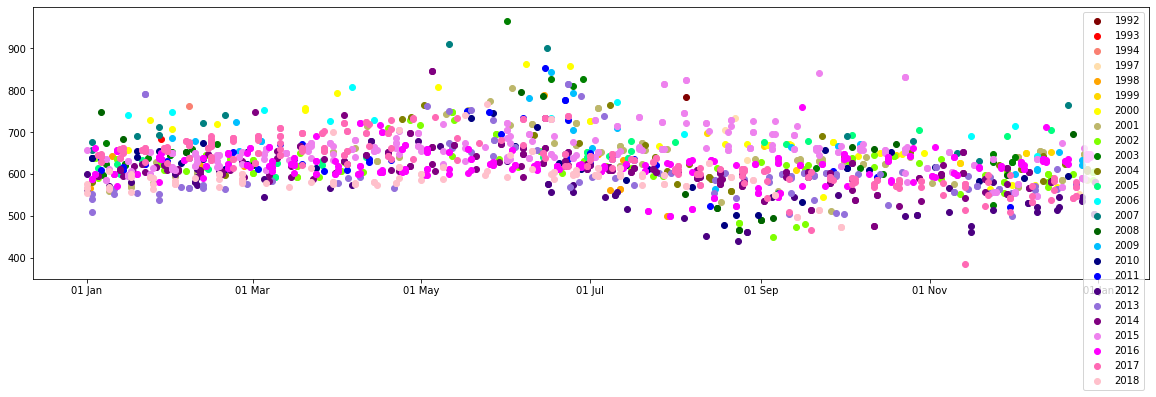

In [46]:
plotting_by_months(long_dt_vels, long_dt_mid_dates)

Monthly plot of all years for dts longer than 64

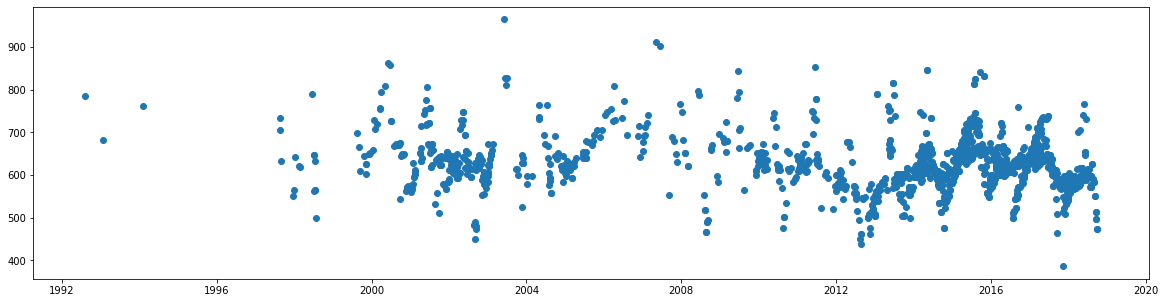

In [47]:
plt.figure(figsize=(20, 5))
plt.scatter(long_dt_mid_dates, long_dt_vels)
plt.show()

In [48]:
long_dt_mean = np.mean(long_dt_vels)

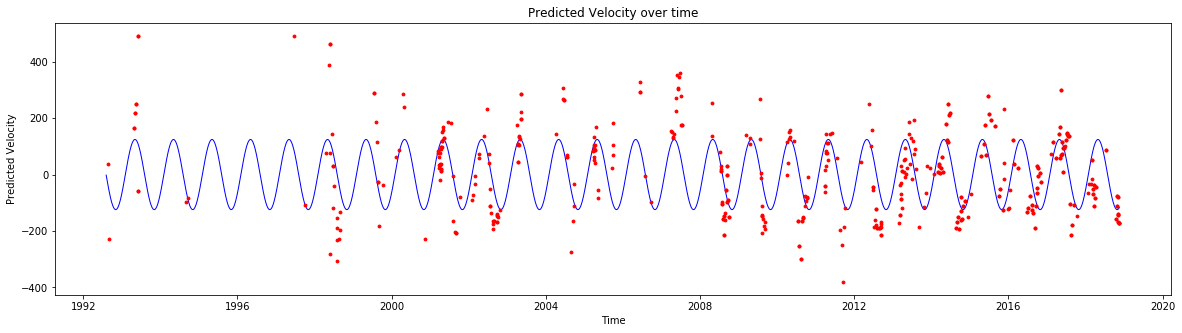

Estimated amplitude: 124.3275, Estimated peak: 04-30


In [49]:
scaled_vels = small_dt_vels - long_dt_mean
velocity_small_dt, dates_small_dt = remove_nan(scaled_vels, small_dt_mid_dates)
times_small_dt = np.array(list(map(datetime.date.toordinal, dates_small_dt)))
est_amp, est_phase = predict_velocity(velocity_small_dt, times_small_dt, velocity_sin_scaled)
pred_vel_small_dt = velocity_sin_scaled(TIME_RANGE, est_amp, est_phase)
est_peak_month, est_peak_day = calc_peak(DATE_RANGE, pred_vel_small_dt)
plotting_same_plot(DATE_RANGE, pred_vel_small_dt, times_small_dt, velocity_small_dt, "Predicted Velocity")
print(f"Estimated amplitude: {round(est_amp, 4)}, Estimated peak: {est_peak_month}-{est_peak_day}")

119


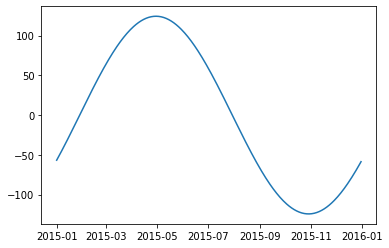

In [50]:
s = datetime.date(2015,1,1).toordinal()
one_year_times = np.array(range(s, s+365))
one_year_dates = np.array(list(map(datetime.date.fromordinal, one_year_times)))
pred_vel_one_year = velocity_sin_scaled(one_year_times, est_amp, est_phase)
plt.plot(one_year_dates, pred_vel_one_year)
print(np.argmax(pred_vel_one_year))

In [51]:
vels_all, img1s_all, img2s_all = get_images_and_vel(gl_cube, x_coord, y_coord)

In [52]:
short_vels, short_img1s, short_img2s = select_by_dt(vels_all, img1s_all, img2s_all, 30)
short_mid_dates = ((short_img2s-short_img1s)/2 + short_img1s).astype('M8[ms]').astype('O')
long_vels, long_img1s, long_img2s = select_by_dt(vels_all, img1s_all, img2s_all, 30, False)
long_mid_dates = ((long_img2s-long_img1s)/2 + long_img1s).astype('M8[ms]').astype('O')
long_vels, long_mid_dates = remove_nan(long_vels, long_mid_dates)
long_mean = np.mean(long_vels)

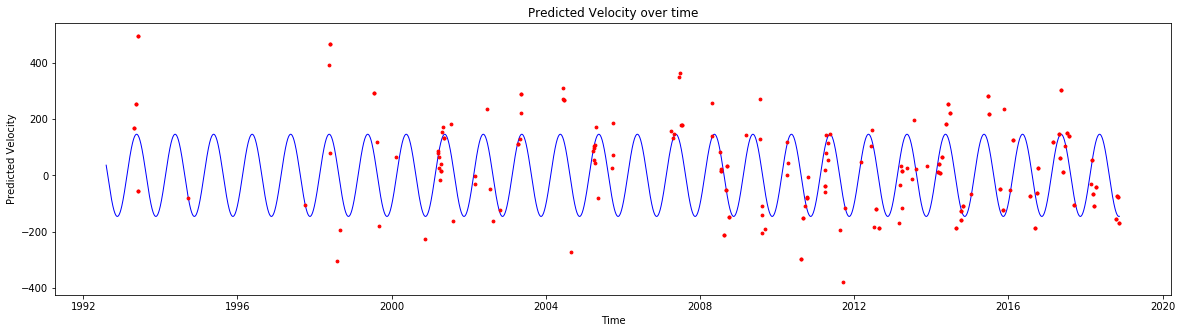

Estimated amplitude: 145.7249, Estimated phase: 349.5104


In [53]:
scaled_vels = short_vels - long_mean
velocity_short, dates_short = remove_nan(scaled_vels, short_mid_dates)
times_short = np.array(list(map(datetime.date.toordinal, dates_short)))
est_amp, est_phase = predict_velocity(velocity_short, times_short, velocity_sin_scaled)
pred_vel_short = velocity_sin_scaled(TIME_RANGE, est_amp, est_phase)
plotting_same_plot(DATE_RANGE, pred_vel_short, times_short, velocity_short, "Predicted Velocity")
print(f"Estimated amplitude: {round(est_amp, 4)}, Estimated phase: {round(est_phase, 4)}")

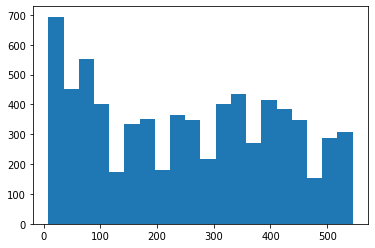

In [54]:
# all_dts, temp = remove_nan(all_dts, all_dts)
plt.hist(all_dts, bins=20)
# all_dts[0].astype('float')
# np.isnan(all_dts[0].astype('float'))
plt.show()

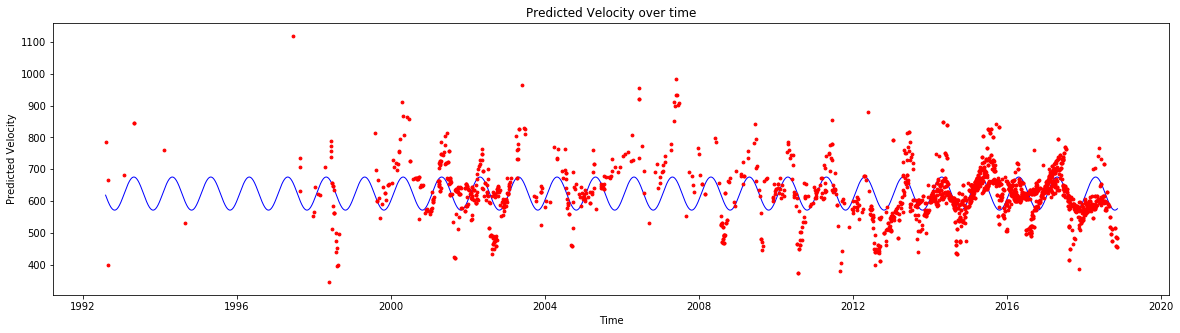

In [55]:
times_long = np.array(list(map(datetime.date.toordinal, long_mid_dates)))
est_vel, est_amp, est_phase = predict_velocity(long_vels, times_long, velocity_sin)
pred_vel_long = velocity_sin(TIME_RANGE, est_vel, est_amp, est_phase)
plotting_same_plot(DATE_RANGE, pred_vel_long, times_long, long_vels, "Predicted Velocity")

# plt.figure(figsize=(20,5))
# plt.scatter(long_mid_dates, long_vels)

In [56]:
vels_train_all, img1s_train_all, img2s_train_all = get_images_and_vel(gl_cube, x_coord, y_coord, [2000, 2015])
vels_test_all, img1s_test_all, img2s_test_all = get_images_and_vel(gl_cube, x_coord, y_coord, [2015, 2019])

In [32]:
def evaluate_model(train_data, test_data, dt, plot=True):
    vels_train_all, img1s_train_all, img2s_train_all = train_data
    vels_test_all, img1s_test_all, img2s_test_all = test_data
    
    vels_train_s, img1s_train_s, img2s_train_s = select_by_dt(vels_train_all, img1s_train_all, img2s_train_all, dt)
    mid_dates_train = ((img2s_train_s-img1s_train_s)/2 + img1s_train_s).astype('M8[ms]').astype('O')
    vels_train_s, mid_dates_train = remove_nan(vels_train_s, mid_dates_train)
    vels_train_l, img1s_train_l, img2s_train_l = select_by_dt(vels_train_all, img1s_train_all, img2s_train_all, dt, False)
    mid_dates_train_l = ((img2s_train_l-img1s_train_l)/2 + img1s_train_l).astype('M8[ms]').astype('O')
    vels_train_l, mid_dates_train_l = remove_nan(vels_train_l, mid_dates_train_l)
    train_l_mean = np.mean(vels_train_l)

    vels_train = vels_train_s - train_l_mean
    vels_train, dates_train = remove_nan(vels_train, mid_dates_train)
    
    times_train = np.array(list(map(datetime.date.toordinal, dates_train)))
    est_amp, est_phase = predict_velocity(vels_train, times_train, velocity_sin_scaled)
    pred_vel_train = velocity_sin_scaled(TIME_RANGE, est_amp, est_phase)
    if plot:
        plotting_same_plot(DATE_RANGE, pred_vel_train, times_train, vels_train, "Predicted Velocity (Train)")
        print(f"Estimated amplitude: {round(est_amp, 4)}, Estimated phase: {round(est_phase, 4)}")
    
    vels_test_s, img1s_test_s, img2s_test_s = select_by_dt(vels_test_all, img1s_test_all, img2s_test_all, dt)
    mid_dates_test = ((img2s_test_s-img1s_test_s)/2 + img1s_test_s).astype('M8[ms]').astype('O')
    vels_test_s, mid_dates_test = remove_nan(vels_test_s, mid_dates_test)
    vels_test_l, img1s_test_l, img2s_test_l = select_by_dt(vels_test_all, img1s_test_all, img2s_test_all, dt, False)
    mid_dates_test_l = ((img2s_test_l-img1s_test_l)/2 + img1s_test_l).astype('M8[ms]').astype('O')
    vels_test_l, mid_dates_test_l = remove_nan(vels_test_l, mid_dates_test_l)
    test_l_mean = np.mean(vels_test_l)

    vels_test = vels_test_s - test_l_mean
    vels_test, dates_test = remove_nan(vels_test, mid_dates_test)
    times_test = np.array(list(map(datetime.date.toordinal, dates_test)))
    
    pred_vel_test = velocity_sin_scaled(times_test, est_amp, est_phase)
    
    vel_rmse = rmse(pred_vel_test, vels_test)
    if plot:
        plotting_same_plot(DATE_RANGE, pred_vel_train, times_test, vels_test, "Predicted Velocity (Test)")
        print(f"RMSE: {vel_rmse}")
    
    return vel_rmse, est_amp, est_phase

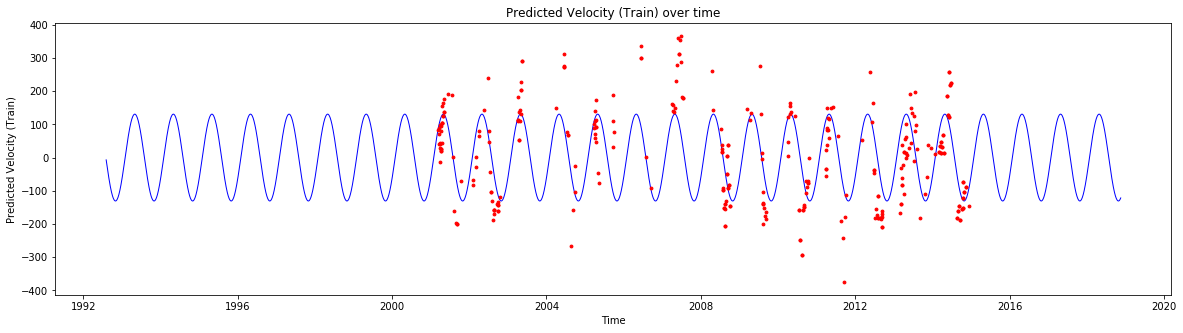

Estimated amplitude: 130.7402, Estimated phase: 331.8759


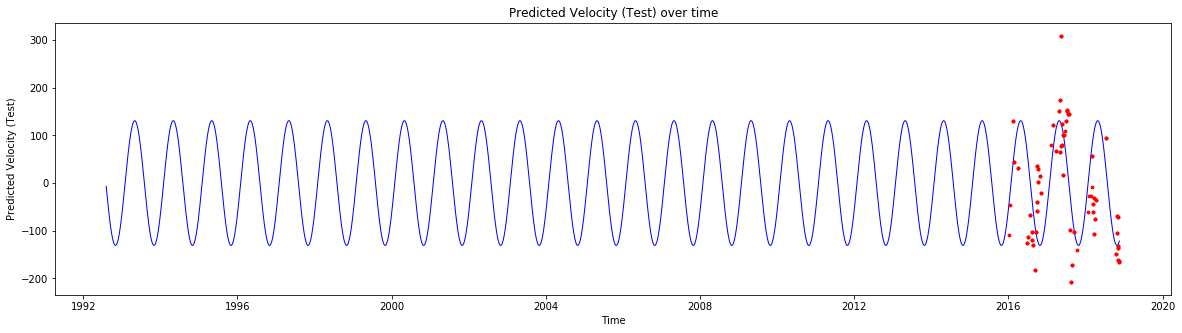

RMSE: 97.95543443506529


In [58]:
train_data = [vels_train_all, img1s_train_all, img2s_train_all]
test_data = [vels_test_all, img1s_test_all, img2s_test_all]
vel_rmse, est_amp, est_phase = evaluate_model(train_data, test_data, 64)

In [59]:
rmses = []
for dt in range(20, 120):
    vel_rmse, est_amp, est_phase = evaluate_model(train_data, test_data, dt, False)
    rmses.append((vel_rmse, est_amp, est_phase))

In [60]:
best_index = rmses.index(max(rmses, key = lambda i : i[0]))
best_dt = best_index + 20

In [61]:
best_dt
best_rmse, best_amp, best_phase = rmses[best_index]
print(best_amp, best_phase)

134.45430431918751 339.209204983727


In [33]:
def calc_prediction(x_coord, y_coord, plot=False):
    train_data = get_images_and_vel(gl_cube, x_coord, y_coord, [2000, 2015])
    test_data = get_images_and_vel(gl_cube, x_coord, y_coord, [2015, 2019])

    rmses = []
    for dt in range(20, 100):
        vel_rmse, est_amp, est_phase = evaluate_model(train_data, test_data, dt, plot)
        rmses.append((vel_rmse, est_amp, est_phase))
        
    best_index = rmses.index(max(rmses, key = lambda i : i[0]))
    best_dt = best_index + 20
    best_rmse, best_amp, best_phase = rmses[best_index]
    
    return best_amp, best_phase
    
    

In [63]:
result = calc_prediction(x_coord, y_coord)
print(result)

(134.45430431918751, 339.209204983727)


In [64]:
amps = []
phases = []
for x_val in range(len(gl_cube.x.values)):
    for y_val in range(len(gl_cube.y.values)):
        start = time.time()
        best_amp, best_phase = calc_prediction(x_coord, y_coord)
#         vel_rmse, est_amp, est_phase = evaluate_model()
        amps.append(est_amp)
        phases.append(est_phase)
        
        end = time.time()
        print(f"Time elapsed: {end - start}")
        break
    break
amps = np.array(amps)
phases = np.array(phases)

Time elapsed: 34.756117820739746


In [65]:
amps

array([125.55226532])

In [66]:
len(gl_cube.x.values) * len(gl_cube.y.values)

173056

In [67]:
a, p = calc_prediction(mid_x, mid_y, False)

In [68]:
p

21.655425110828464

In [34]:
def run_predict(vels_all, img1s_all, img2s_all, dt, plot=True):
#     vels_all, img1s_all, img2s_all = get_images_and_vel(gl_cube, x_coord, y_coord, [1992, 2019])
    vels_s, img1s_s, img2s_s = select_by_dt(vels_all, img1s_all, img2s_all, dt)
    mid_dates_s = ((img2s_s-img1s_s)/2 + img1s_s).astype('M8[ms]').astype('O')
    vels_s, mid_dates_s = remove_nan(vels_s, mid_dates_s)
    vels_l, img1s_l, img2s_l = select_by_dt(vels_all, img1s_all, img2s_all, dt, False)
    mid_dates_l = ((img2s_l-img1s_l)/2 + img1s_l).astype('M8[ms]').astype('O')
    vels_l, mid_dates_l = remove_nan(vels_l, mid_dates_l)
    long_mean = np.mean(vels_l)
    vels_scaled = vels_s - long_mean
    vels_scaled, dates = remove_nan(vels_scaled, mid_dates_s)
    times = np.array(list(map(datetime.date.toordinal, dates)))
    
    est_amp, est_phase = predict_velocity(vels_scaled, times, velocity_sin_scaled)
    
    pred_vel = velocity_sin_scaled(TIME_RANGE, est_amp, est_phase)
    
    est_peak_month, est_peak_day = calc_peak(DATE_RANGE, pred_vel)

    if plot:
        plotting_same_plot(DATE_RANGE, pred_vel, dates, vels_scaled, "Predicted Velocity")
        print(f"Estimated amplitude: {round(est_amp, 4)}, Estimated peak: {est_peak_month}-{est_peak_day}")

In [70]:
start = time.time()
vels_all, img1s_all, img2s_all = get_images_and_vel(gl_cube, x_coord, y_coord)
end = time.time()
print(end-start)

24.31277370452881


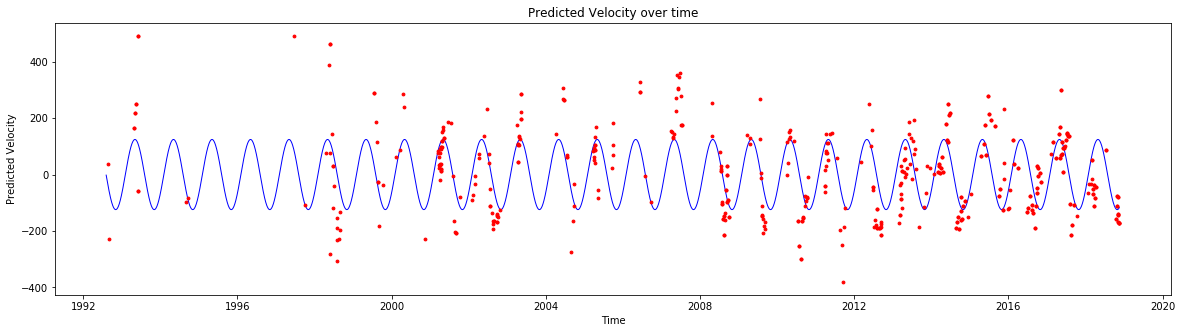

Estimated amplitude: 124.3275, Estimated peak: 04-30


In [71]:
run_predict(vels_all, img1s_all, img2s_all, 64)

In [21]:
# load data
v = gl_cube.v
x = gl_cube.x
y = gl_cube.y
mid_dates = gl_cube.mid_date
im1 = gl_cube.acquisition_img2
im2 = gl_cube.acquisition_img1
dts = gl_cube.date_dt

In [22]:
vm = v[dts > 64, :, :].median(dim='mid_date', skipna=True)

In [23]:
v = v[dts <= 64, :, :]
mid_dates = mid_dates[dts <= 64]
im1 = im1[dts <= 64]
im2 = im2[dts <= 64]

In [35]:
def pred(vels_all, mid_dates, median, plot=False):
    vels_scaled = vels_all - median
    vels_scaled, dates = remove_nan(vels_scaled, mid_dates)
    d = dates.astype('M8[ms]').astype('O')
    times = np.array(list(map(datetime.date.toordinal, d)))
    pred_vel = None
    try:
        est_amp, est_phase = predict_velocity(vels_scaled, times, velocity_sin_scaled)
        pred_vel = velocity_sin_scaled(TIME_RANGE, est_amp, est_phase)
        est_peak = DATE_RANGE[np.argmax(pred_vel)]
    except:
        est_amp = np.nan
        est_phase = np.nan
        est_peak = np.nan

    if plot and pred_vel is not None:
        plotting_same_plot(DATE_RANGE, pred_vel, d, vels_scaled, "Predicted Velocity")
        print(f"Estimated amplitude: {round(est_amp, 4)}, Estimated peak: {est_peak}")
    return est_amp, est_phase, est_peak

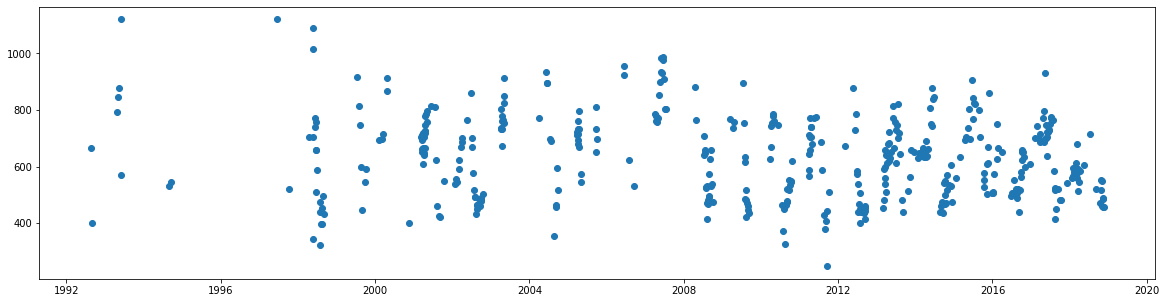

In [25]:
test_vel = v.isel(x=x_coord, y=y_coord)
test_med = vm.isel(x=x_coord, y=y_coord).values.item()
plt.figure(figsize=(20, 5))
plt.scatter(mid_dates.values, test_vel.values)
# pred(test_vel, mid_dates.values, test_med)

In [ ]:
amps = []
phases = []
peaks = []
start = time.time()
for x_val in range(len(x)):
    if x_val%50 == 0:
        print(x_val)
    for y_val in range(len(y)):
        vel = v.isel(x=x_val, y=y_val).values
        med = vm.isel(x=x_val, y=y_val).values.item()
        est_amp, est_phase, est_peak = pred(vel, mid_dates.values, med)
        amps.append(est_amp)
        phases.append(est_phase)
        peaks.append(est_peak)
end = time.time()
print(end - start)

In [81]:
amps = np.array(amps)
new_amps = np.reshape(amps, (len(x), len(y)))

In [82]:
all_amps = xr.DataArray(new_amps, dims=("x", "y"), coords={'x':x, 'y':y})

In [83]:
new_peaks = np.array(peaks)
peak_months = np.array([np.nan if type(p) == float else p.month for p in new_peaks])
peak_months = np.reshape(peak_months, (len(x), len(y)))
all_peaks = xr.DataArray(peak_months, dims=("x", "y"), coords={'x':x, 'y':y})

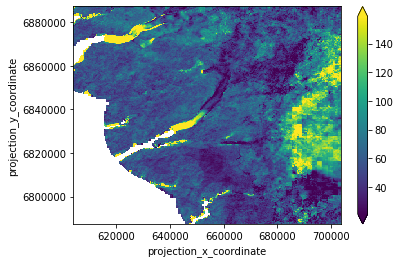

Max amplitude: <xarray.DataArray ()>
array(9530.420765), Min amplitude: <xarray.DataArray ()>
array(0.00037798)


In [84]:
all_amps.plot(x='x', y='y', robust=True)
plt.show()
print(f"Max amplitude: {np.max(all_amps)}, Min amplitude: {np.min(all_amps)}")

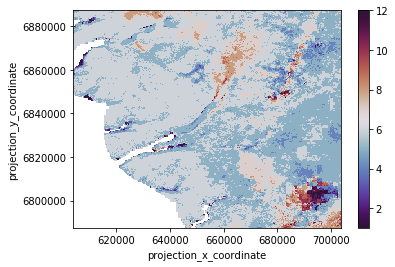

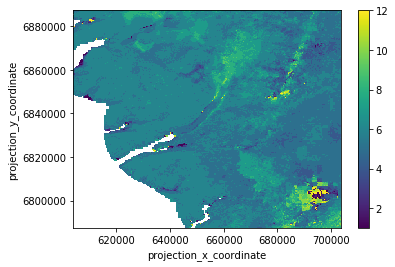

In [85]:
all_peaks.plot(x='x', y='y', cmap='twilight_shifted')
plt.show()
all_peaks.plot(x='x', y='y')
plt.show()

In [86]:
max_amp = all_amps.where(all_amps==all_amps.max(), drop=True)
max_x = max_amp.x.values.item()
max_y = max_amp.y.values.item()

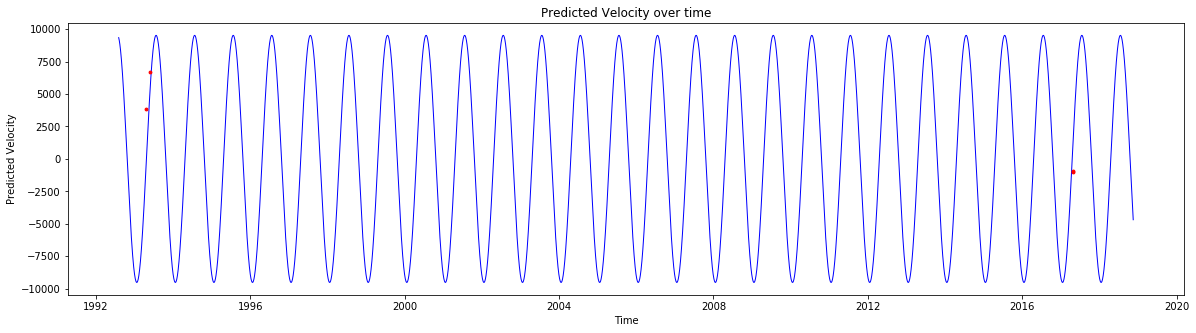

Estimated amplitude: 9530.4208, Estimated peak: 2004-07-22


In [87]:
vel = v.sel(x=max_x, y=max_y).values
med = vm.sel(x=max_x, y=max_y).values.item()
est_amp, est_phase, est_peak = pred(vel, im1.values, im2.values, mid_dates.values, med, True)

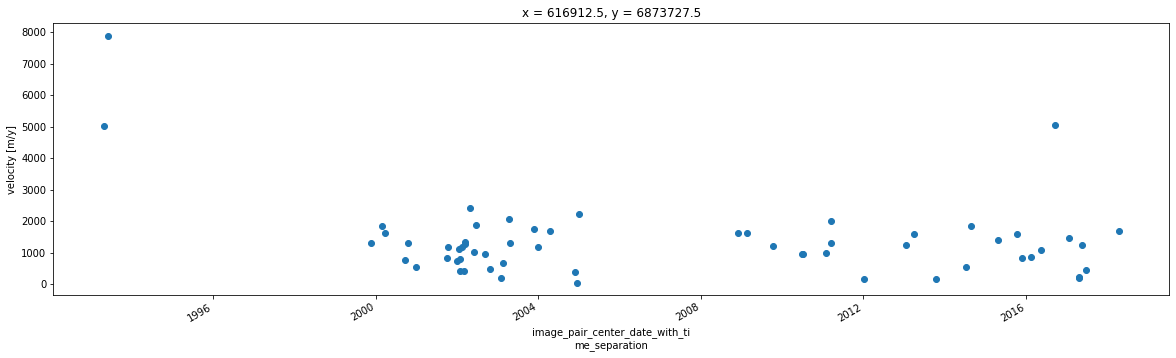

In [88]:
max_v = gl_cube.v.sel(x=max_x, y=max_y)
max_v.plot(marker='o', linestyle="None", figsize=(20, 5))
plt.show()

In [106]:
threshold = (3*v.median(dim='mid_date', skipna=True)).stack(grid_cell=("x", "y"))

In [91]:
v2 = v-vm

In [93]:
v2 = v2.stack(grid_cell=("x", "y"))

In [157]:
amps = np.full(v2.sizes['grid_cell'], np.nan)
phases = np.full(v2.sizes['grid_cell'], np.nan)
peaks = np.full(v2.sizes['grid_cell'], np.nan, dtype=datetime.date)

In [36]:
def predict_fit(vels, mid_dates, plot=False):
    d = mid_dates.astype('M8[ms]').astype('O')
    times = np.array(list(map(datetime.date.toordinal, d)))
    est_amp, est_phase = predict_velocity(vels, times, velocity_sin_scaled)
    pred_vel = velocity_sin_scaled(TIMES, est_amp, est_phase)
    est_peak = DATES[np.argmax(pred_vel)]

    if plot and pred_vel is not None:
        plotting_same_plot(DATES, pred_vel, d, vels, "Predicted Velocity")
        print(f"Estimated amplitude: {round(est_amp, 4)}, Estimated peak: {est_peak}")
    return est_amp, est_phase, est_peak

In [272]:
start = time.time()

In [273]:
discarded = 0
for i in range(v2.sizes['grid_cell']):
    ind = v2[:, i] <= threshold[i].values
    if sum(ind.values) > 30:
        if i%10000==0:
            print(i)
        est_amp, est_phase, est_peak = predict_fit(v2[:, i][ind].values, mid_dates[ind].values)
        amps[i] = est_amp
        phases[i] = est_phase
        peaks[i] = est_peak
    else:
        discarded += 1

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000


In [274]:
end = time.time()
print(end - start)

1058.7198169231415


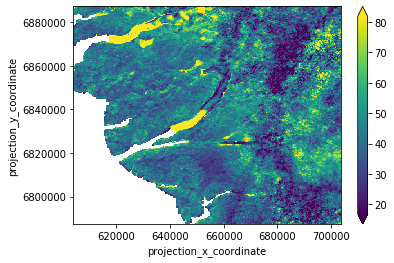

Max amplitude: 3224.610459019691, Min amplitude: 0.4914797016458586


In [279]:
pred_amps = np.reshape(amps, (len(x), len(y)))
pred_amps = xr.DataArray(pred_amps, dims=("x", "y"), coords={'x':x, 'y':y})

pred_amps.plot(x='x', y='y', robust=True)
plt.show()
print(f"Max amplitude: {np.nanmax(pred_amps.values)}, Min amplitude: {np.nanmin(pred_amps.values)}")

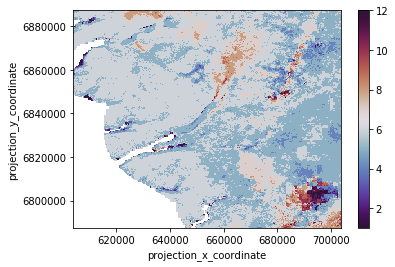

In [281]:
pred_peaks = np.array([np.nan if type(p) == float else p.month for p in peaks])
pred_peaks = np.reshape(peaks, (len(x), len(y)))
pred_peaks = xr.DataArray(peak_months, dims=("x", "y"), coords={'x':x, 'y':y})

all_peaks.plot(x='x', y='y', cmap='twilight_shifted')
plt.show()

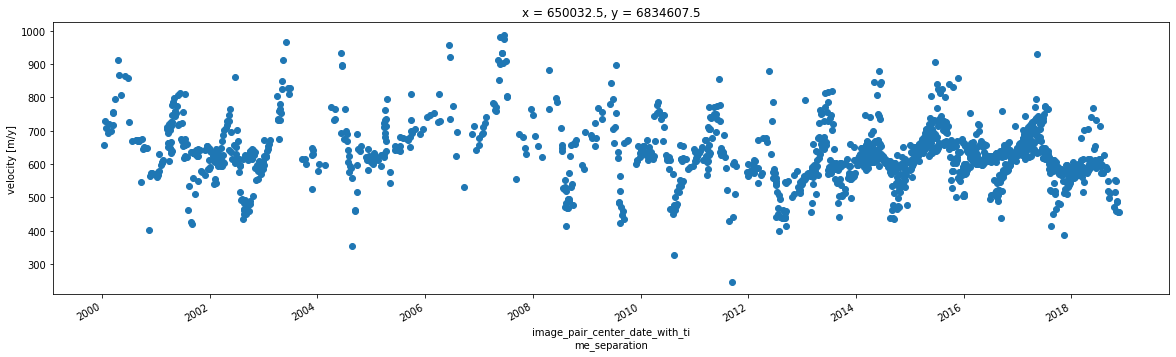

In [21]:
# REMOVING INTERANNUAL VARIABILITY

cell = gl_cube.v.isel(x=x_coord, y=y_coord)
cell = cell.where(cell.mid_date > np.datetime64("2000"))

v_error = np.sqrt(gl_cube.vx_error**2 + gl_cube.vy_error**2)
threshold = 2.5 * 1.4826 * v_error

upper_threshold = cell.median(dim='mid_date', skipna=True) + threshold
lower_threshold = cell.median(dim='mid_date', skipna=True) - threshold
mask = cell <= upper_threshold
mask = cell >= lower_threshold
cell = cell[mask]
cell_mid_dates = gl_cube.mid_date[mask]
cell.plot(marker='o', linestyle='None', figsize=(20,5))
dts = gl_cube.date_dt[mask]
v_error = v_error[mask]

min_date = min(cell_mid_dates).values.astype('M8[ms]').astype('O').year
max_date = max(cell_mid_dates).values.astype('M8[ms]').astype('O').year
# cell_short = cell[dts <= 91]
# cell_long = cell[dts > 183]
# cell_short_mid_dates = mid_dates[dts <= 40]
# cell_short.plot(marker='o', linestyle='None', figsize=(20,5))
# cell_long.plot(marker='o', linestyle='None', figsize=(20,5))

In [22]:
weighted_vels = []
weighted_dates = []
cell_years = []
for year in range(min_date, max_date+1):
    cell_years.append(year)
    cell_year = cell.where(cell.mid_date >= np.datetime64(year, 'Y')-1970).where(cell.mid_date < np.datetime64(year+1, 'Y')-1970) 
    year_mask = np.isfinite(cell_year)
    cell_year = cell_year[year_mask]
    v_error_year = v_error[year_mask]
    
    first = datetime.date(year, 1, 1).toordinal()
    cell_mid_dates_year = cell_mid_dates[year_mask].values.astype('M8[ms]').astype('O')
    cell_mid_dates_year = np.array(list(map(datetime.date.toordinal, cell_mid_dates_year))) - first
    weights = 1/v_error_year**2

    weighted_cell = weights/sum(weights)*cell_year
    weighted_vels.append(sum(weighted_cell.values))
    
    weighted_date = weights/sum(weights)*cell_mid_dates_year
#     weighted_dates.append(datetime.date.fromordinal(int(sum(weighted_date.values) + first)))
    weighted_dates.append(sum(weighted_date.values)+first)
#     print(datetime.date.fromordinal(int(sum(weighted_date.values) + first)))
    
cell_years = np.array(cell_years)
weighted_vels = np.array(weighted_vels)
weighted_dates = np.array(weighted_dates)
w_d = list(map(datetime.date.fromordinal, weighted_dates.astype(int)))
    
#     weighted_mid_date = weights/sum(weights)*cell_mid_dates_year.astype('M8[ms]').astype('O')
#     weighted_mid_date.astype(np.datetime64)

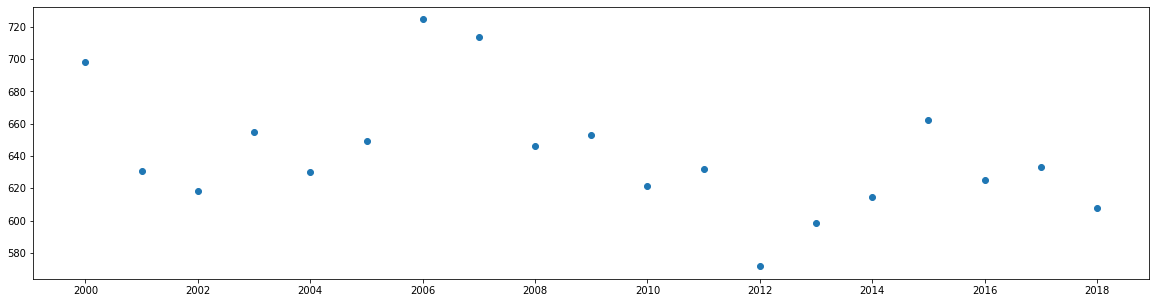

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


In [24]:
cell_years_dates = cell_years.astype('M8[Y]')-1970
plt.figure(figsize=(20,5))
plt.scatter(cell_years_dates, weighted_vels)
plt.show()
poly_model = np.polyfit(cell_years, weighted_vels, 6)

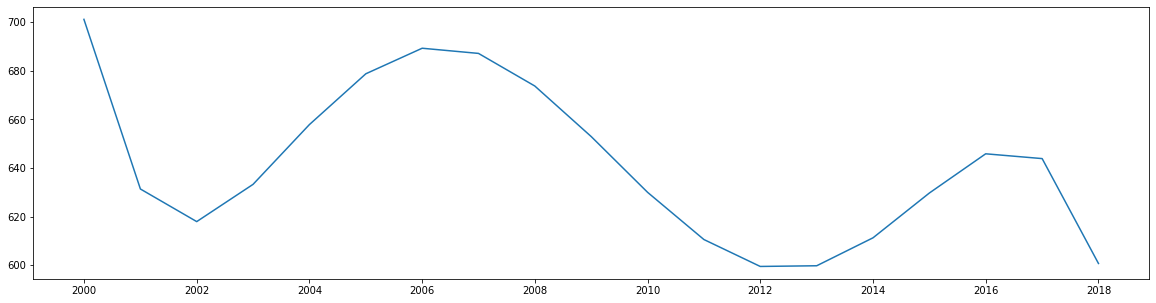

In [25]:
date_range = np.arange(cell_years_dates[0], cell_years_dates[-1], dtype='datetime64[D]')
time_range = date_range.astype(float)
time_range = time_range - date_range[0].astype(float)
interannual_var = np.polyval(poly_model, cell_years)
plt.figure(figsize=(20,5))
plt.plot(cell_years_dates, interannual_var)
plt.show()

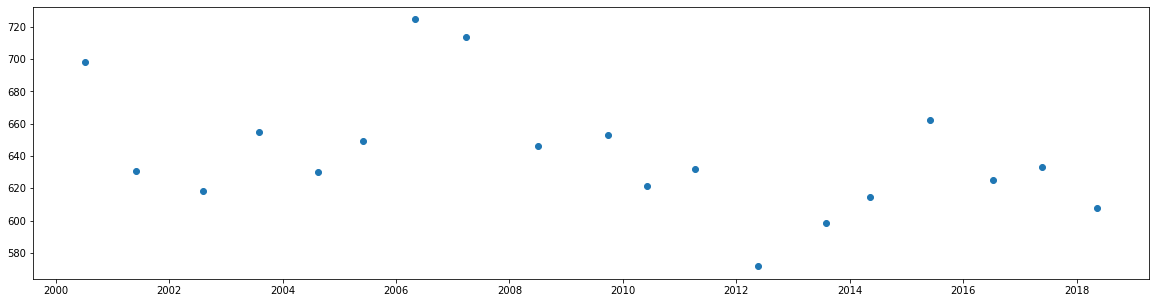

In [26]:
plt.figure(figsize=(20,5))
plt.scatter(w_d, weighted_vels)
plt.show()

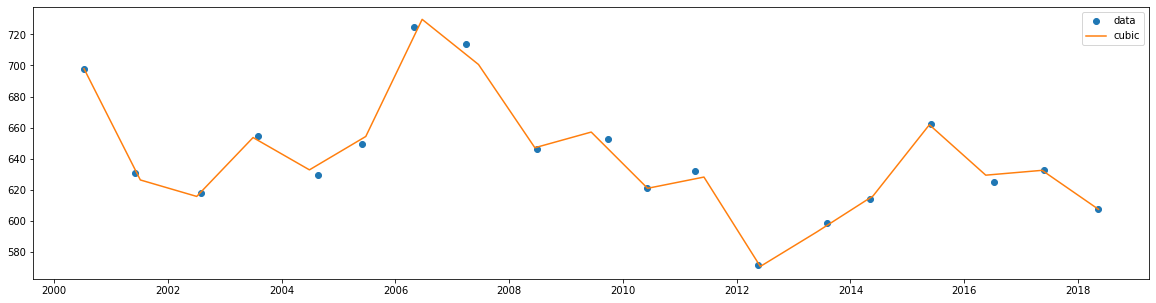

In [27]:
# f = interp1d(cell_years, interannual_var)
# f2 = interp1d(cell_years, interannual_var, kind='cubic')
FIRST = min(weighted_dates)
LAST = max(weighted_dates)
f = interp1d(weighted_dates, weighted_vels, kind='cubic')
xnew = np.linspace(FIRST, LAST, num=len(cell_years), endpoint=True)
plt.figure(figsize=(20,5))
plt.plot(w_d, weighted_vels, 'o', xnew, f(xnew), '-')
plt.legend(['data', 'cubic'], loc='best')
plt.show()

ia_var = f(xnew)

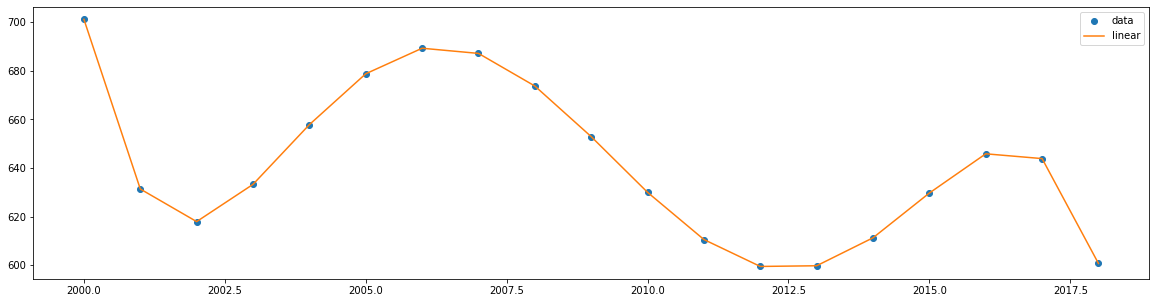

In [28]:
f = interp1d(cell_years, interannual_var, kind='cubic')
xnew = np.linspace(min_date, max_date, len(cell_years), endpoint=True)

plt.figure(figsize=(20,5))
plt.plot(cell_years, interannual_var, 'o', xnew, f(xnew), '-')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

ia_var2 = ia_var = f(xnew)

In [29]:
ia_var

array([701.09375, 631.34375, 617.9375 , 633.25   , 657.8125 , 678.71875,
       689.21875, 687.09375, 673.6875 , 652.875  , 629.96875, 610.5625 ,
       599.5    , 599.78125, 611.28125, 629.6875 , 645.8125 , 643.84375,
       600.71875])

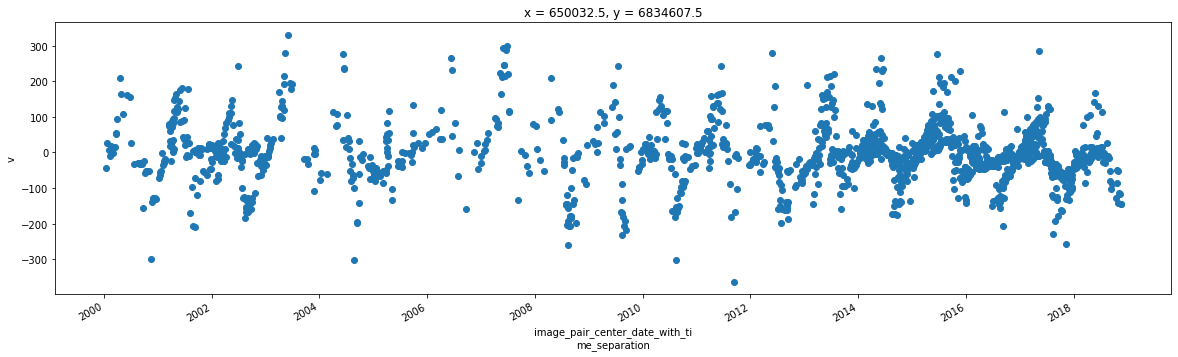

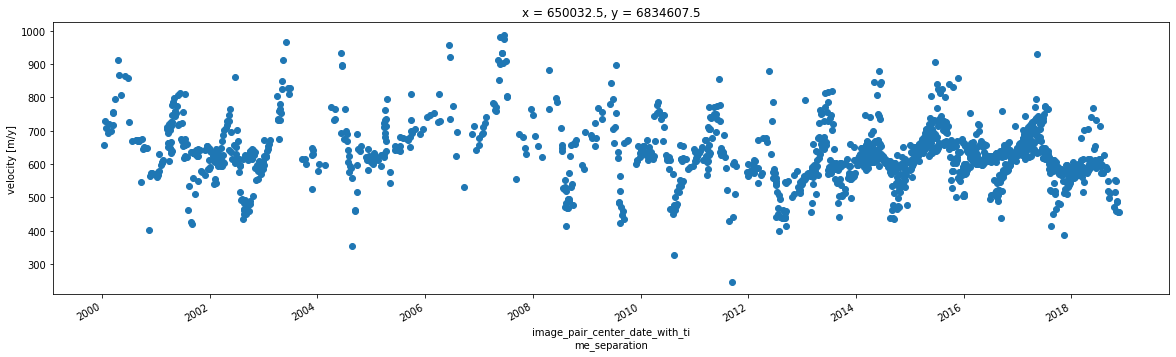

In [30]:
removed = None
removed2 = None

for year in range(min_date, max_date+1):
    cell_year = cell.where(cell.mid_date >= np.datetime64(year, 'Y')-1970).where(cell.mid_date < np.datetime64(year+1, 'Y')-1970) 
    year_mask = np.isfinite(cell_year)
    cell_year = cell_year[year_mask]
    index = year - cell_years[0]
    removed_ia_var = cell_year - ia_var[index]
    removed_ia_var2 = cell_year - ia_var2[index]
    if year == min_date:
        removed = removed_ia_var
        removed2 = removed_ia_var2
    else:
        removed = xr.merge([removed, removed_ia_var])
        removed2 = xr.merge([removed2, removed_ia_var2])
removed.v.plot(marker='o', linestyle="None", figsize=(20, 5))
# removed2.v.plot(marker='o', linestyle="None", figsize=(20, 5))
cell.plot(marker='o', linestyle='None', figsize=(20,5))

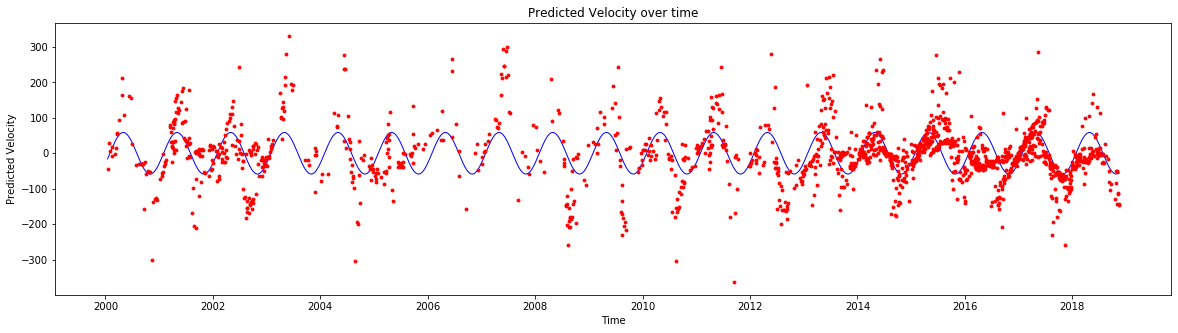

Estimated amplitude: 58.5682, Estimated peak: 2009-04-30


In [38]:
times = np.array(list(map(datetime.date.toordinal, removed.mid_date.values.astype('M8[ms]').astype('O'))))
TIMES = np.array(range(min(times), max(times)+1))
DATES = np.array(list(map(datetime.date.fromordinal, TIMES)))
est_amp, est_phase, est_peak = predict_fit(removed.v.values, removed.mid_date.values, True)

In [39]:
# DISPLACEMENT METHOD
dyr = dts/365.25
weights = 1/(v_error * dyr)

In [41]:
weights

<xarray.DataArray (mid_date: 1606)>
array([0.01785245, 0.03100745, 0.01040622, ..., 0.05927203, 0.07749192,
       0.10256524])
Coordinates:
  * mid_date  (mid_date) datetime64[ns] 2016-11-19T00:00:00.320000 ... 2005-0...
    x         float64 6.5e+05
    y         float64 6.835e+06

In [42]:
removed

<xarray.Dataset>
Dimensions:   (mid_date: 1606)
Coordinates:
  * mid_date  (mid_date) datetime64[ns] 2000-01-16T00:00:00.160000 ... 2018-1...
    x         float64 6.5e+05
    y         float64 6.835e+06
Data variables:
    v         (mid_date) float32 -43.09 27.91 6.906 ... -115.7 -144.7 -143.7